# Union of K intervals


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [387]:
class union_interval:
    def __init__(self, k = 3, epsilon = 0.1, gamma = 0.1, space = [-5,5], noise = 0, const_w = False):
        self.intervals = np.sort(np.random.uniform(space[0] + 0.0001,space[1],2*k)).reshape(k,2)#intervals always smaller than sample space
        self.ep = epsilon
        self.gamma = gamma
        self.space = space #[space[0] + 0.0001, space[1] - 0.001]#ensure bu
        self.noise = noise
        self.const_w = const_w
        self.k = k
        self.examples = np.array((space[0] - 1, 0, 0)).reshape(1,-1)#will always be ignored

    def add_example(self, ex):
        if ex.ndim == 1:#1d array
            self.examples = np.vstack((self.examples, ex))
        elif ex.ndim == 2:#2d array
            self.examples = np.concatenate((self.examples, ex), axis =0)#needs to be list
            
    def bin_search(intervals, i, k = 0):
        j = len(intervals)
        if j <= 1:
            return k
        if i < intervals[j//2]:
            return bin_search(intervals[:j//2], i, k)
        else:
            return bin_search(intervals[j//2:], i, k + j//2)
        
    def in_intervals(intervals, i):
        indx = bin_search(intervals[:,0], i)
        return intervals[indx, 0] <= i <= intervals[indx, 1]
        
    def sample(self, m = 1, samp = None, weight = None, label = None):
        if m == 1:
            samp = samp or np.random.uniform(self.space[0], self.space[1])
            weight = float(weight or self.const_w or np.random.uniform(0,1))#wieghts random between 0 and 1
            label = label or in_intervals(self.intervals, samp)
            self.add_example(np.array((samp, weight, label)))
        else:
            samples = np.random.uniform(*self.space, m)
            weights = np.random.uniform(int(self.const_w), 1, m)
            labels = np.array([in_intervals(self.intervals, i) for i in samples])
            self.add_example(np.column_stack((samples, weights, labels)))            
    
    def permute(self):
        filtered = self.examples[len(self.examples)*noise,]
    
    def estimate_intervals(self):
        self.examples = self.examples[np.argsort(self.examples[:,0]), :]
        permuted_ex = self.examples[:,2]
        made_intervals = [self.examples[:-1,2] != self.examples[1:,2]]#compare labels
        startstop = [0] + [i if i %2 == 1 else 0 for i in np.cumsum(made_intervals)]
        _, groups = np.unique(startstop, return_inverse = True)#need to exclude 0 group, need to leave in for spaceing
        num_vals = max(groups)
        indicies = [[] for i in range(num_vals+1)]#list of list of intervals locs [most specific]
        for counter, val in enumerate(groups):
            indicies[val].append(counter)#appends row index of interval at its group
        del indicies[0]
        weights = [0]*len(indicies)
        for cnter, lst in enumerate(indicies):
            weights[cnter] = np.mean(self.examples[lst, 1])
        final_indxs = [j for i,j in sorted(zip(weights, indicies), key = lambda x: x[0])][-self.k:]#is sorted in ascending order
        final_intervals = [0]*self.k
#         print(final_indxs, "\n\n", max([len(i) for i in indicies]))
        for cnt, lst in enumerate(final_indxs):
            if len(lst) == 1:
                final_intervals[cnt] = [self.examples[lst[0],0]]
            else: 
                final_intervals[cnt] = list((self.examples[lst[0],0], self.examples[lst[-1],0]))#+ self.examples[lst,0][-1]#get's first and last value in index
        return final_intervals

In [388]:
test1 = union_interval(k = 5)
test1.sample(m = 1000)
test1.examples = np.delete(test1.examples, 0, 0) 
est = test1.estimate_intervals()
tru = test1.intervals
print(est, "\n\n", tru)

[[-4.99410356  0.98993005  0.        ]
 [-4.96600815  0.61102679  0.        ]
 [-4.96577504  0.95493713  0.        ]
 ...
 [ 4.9692154   0.89302243  1.        ]
 [ 4.98793556  0.10098097  1.        ]
 [ 4.99272107  0.8290165   1.        ]]
[[-1.4011851874595838, -1.2139701934382643], [3.3002235143918153, 4.992721074345706], [1.39446689722151, 2.845443464864614], [0.29874607335746894, 0.752216206827705], [-4.601487918045625, -4.224281286030848]] 

 [[-4.60788776 -4.21219997]
 [-1.42210501 -1.21195277]
 [ 0.29732888  0.75928251]
 [ 1.3823287   2.85281273]
 [ 3.29901965  4.9971257 ]]


In [384]:
print(test1.intervals, "\n\n\n", )
test1.examples[:,2].sum()

[[-4.25019392 -2.66335482]
 [-2.60564533 -2.3774418 ]
 [-1.60192371  1.31492414]
 [ 2.09121126  2.76124769]
 [ 2.96068774  3.35214897]]


563.0

[[-4.99410356  0.98993005  0.        ]
 [-4.96600815  0.61102679  0.        ]
 [-4.96577504  0.95493713  0.        ]
 ...
 [ 4.9692154   0.89302243  1.        ]
 [ 4.98793556  0.10098097  1.        ]
 [ 4.99272107  0.8290165   1.        ]]


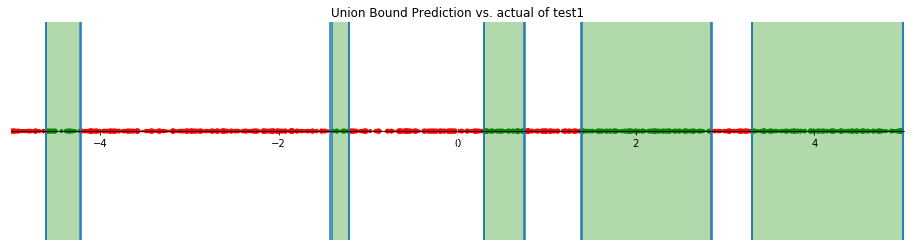

In [393]:
from matplotlib import colors
import matplotlib.transforms as mtransforms

def plot_union(un_int, name = "test"):
    fig = plt.figure(figsize = (16, 4))
    ax = fig.add_subplot(1,1,1)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['left'].set_color('white')
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_visible(False)
    plt.xlim(un_int.space)
    plt.ylim([-1,1])
    clrs = un_int.examples[:,2]
    wghts = un_int.examples[:,1]
    xvals = un_int.examples[:,0]
    cmap = colors.ListedColormap(['red', 'green'])
    plt.scatter(xvals,[0]*len(xvals), s = wghts*100/un_int.k, c = clrs, cmap = cmap)#be better as bars not pnts
    plt.title("Union Bound Prediction vs. actual of " + name)
    est_bnds = un_int.estimate_intervals()
    tru_bnds = un_int.intervals
    plt_bnds(est_bnds, ax, 'green', 0.3)
    plt_bnds(tru_bnds, ax, 'xkcd:lime', 0.05)

def plt_bnds(tru_bnds, ax, clr, alpha = 0.1):
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    for bnd in tru_bnds:
        plt.axvline(x=bnd[0])
        plt.axvline(x=bnd[-1])
        x = np.arange(*bnd, 0.01)
        ax.fill_between(x, 0, 1, where= x >= bnd[0],
                facecolor=clr, alpha=alpha, transform=trans)#fills between all valid pnts
        
plot_union(test1, "test1")
